In [27]:
baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"c9a75a056da4fcd072dbe6951190537d"}
import requests

def get(path, params=None):
# make HTTP GET request to path
    headers = {"api-key":"c9a75a056da4fcd072dbe6951190537d"}
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
    with open(filename, 'wb') as f:
         f.write(r.content)
    return filename # return the filename string

    return r

Check base simulations

In [28]:
r=get(baseUrl)
names = [sim['name'] for sim in r['simulations']]


In [29]:
names

['Illustris-1',
 'Illustris-1-Dark',
 'Illustris-2',
 'Illustris-2-Dark',
 'Illustris-3',
 'Illustris-3-Dark',
 'TNG100-1',
 'TNG100-1-Dark',
 'TNG100-2',
 'TNG100-2-Dark',
 'TNG100-3',
 'TNG100-3-Dark',
 'TNG300-3',
 'TNG300-2-Dark',
 'TNG300-2',
 'TNG300-1-Dark',
 'TNG300-1',
 'TNG300-3-Dark',
 'Illustris-1-Subbox0',
 'Illustris-1-Subbox1',
 'Illustris-1-Subbox2',
 'Illustris-1-Subbox3',
 'Illustris-2-Subbox0',
 'Illustris-2-Subbox1',
 'Illustris-2-Subbox2',
 'Illustris-2-Subbox3',
 'Illustris-3-Subbox0',
 'Illustris-3-Subbox1',
 'Illustris-3-Subbox2',
 'Illustris-3-Subbox3',
 'TNG100-1-Subbox0',
 'TNG100-1-Subbox1',
 'TNG100-2-Subbox0',
 'TNG100-2-Subbox1',
 'TNG100-3-Subbox0',
 'TNG100-3-Subbox1',
 'TNG300-3-Subbox1',
 'TNG300-3-Subbox2',
 'TNG300-3-Subbox0',
 'TNG300-2-Subbox1',
 'TNG300-2-Subbox2',
 'TNG300-2-Subbox0',
 'TNG300-1-Subbox1',
 'TNG300-1-Subbox2',
 'TNG300-1-Subbox0']

In [30]:
mass_min = 10**11.99 / 1e10 *0.704
mass_max = 10**12.01 / 1e10 *0.704

search_query = "?mass__gt=" + str(mass_min) + "&mass__lt=" + str(mass_max)

url = "http://www.tng-project.org/api/TNG100-1/snapshots/z=0/subhalos/" + search_query

subhalos = get(url)

# Number of relevant subhalos
print(subhalos['count'])



94


Find the closest subhalo to $10^{12}\,\mathrm{M}_\odot$

In [31]:
mass=[]
for i in range(subhalos['count']):
    mass.append(subhalos['results'][i]['mass_log_msun'])


In [32]:
index=np.where(np.abs(np.asarray(mass)-12.)==min(np.abs(np.asarray(mass)-12.)))[0][0]

In [33]:
id = subhalos['results'][index]['id']
mass = subhalos['results'][index]['mass_log_msun']
print(id,mass)

509079 11.999996915511192


In [34]:
import h5py
import numpy as np

which_sim = 'TNG100-1'
redshift = 0.0
params = {'stars':'GFM_Metals,GFM_StellarFormationTime'}

scale_factor = 1.0 / (1+redshift)
little_h = 0.704
solar_Z = 0.0127

url = "http://www.tng-project.org/api/"+str(which_sim)+"/snapshots/z=" + str(redshift) + "/subhalos/" + str(id)
print(url)
#sub = get(url) # get json response of subhalo properties
#saved_filename = get(url + "/cutout.hdf5",params) # get and save HDF5 cutout file

http://www.tng-project.org/api/TNG100-1/snapshots/z=0.0/subhalos/509079


In [1]:
input_filename='/mnt/store1/oliverphilcox/ChempyMultiData/TNG_Abun/cutout_509079.hdf5'

In [2]:
import h5py
with h5py.File(input_filename) as f:
    all_metal_fractions = f['PartType4']['GFM_Metals'][:]
    metal_names=['H', 'He', 'C', 'N', 'O','Ne', 'Mg', 'Si', 'Fe','rest']
    star_formation_time_scale_factor= f['PartType4']['GFM_StellarFormationTime'][:]

In [149]:
# Import solar abundances
import os
os.chdir('/home/oliverphilcox/ChempyMulti/')
from Chempy.solar_abundance import solar_abundances
solar=solar_abundances()
getattr(solar,'Asplund09')()#5_pure_solar')()

# First get correct photospheric abundances and masses
good_els = metal_names[:-1] # exclude 'rest'
el_masses=np.zeros(len(good_els))
phot_abuns=np.zeros(len(good_els))
no_fractions = np.zeros([len(all_metal_fractions),len(good_els)])
for e,el in enumerate(good_els):
    for i in range(len(solar.all_elements)):
        if solar.all_elements[i]==el:
            el_masses[e]=solar.all_element_masses[i]
            phot_abuns[e]=solar.table['photospheric'][i]
            break
        if i==len(solar.all_elements)-1:
            raise Exception('Failed to find element %s'%el)
    if el=='Fe':
        Fe_index = e
    if el=='H':
        H_index = e
    no_fractions[:,e]=all_metal_fractions[:,e]/el_masses[e]

# Now normalize by H and find [X/H] abundances:
star_abun=np.zeros_like(no_fractions)
for e in range(len(good_els)):
    star_abun[:,e] = np.log10(no_fractions[:,e]/no_fractions[:,H_index])+12.-phot_abuns[e]
    
# Now convert to [X/Fe] abuns:
for e,el in enumerate(good_els):
    if el!='Fe':
        star_abun[:,e]-=star_abun[:,Fe_index]
    else:
        pass # keep Fe/H form
    
# Now reorder to match TNG
el_names = ['C','Fe','He','Mg','N','Ne','O','Si'] # TNG elements
TNG_abun = np.zeros([len(star_abun),len(el_names)])
for e,el in enumerate(el_names):
    for m in range(len(good_els)):
        if good_els[m]==el:
            TNG_abun[:,e]=star_abun[:,m]
            break



Convert to time from scale-factor using Planck 2015 cosmology:

In [150]:
from astropy.cosmology import Planck15
star_formation_redshifts= [1./a-1. for a in star_formation_time_scale_factor]
star_formation_times = Planck15.age(np.asarray(star_formation_redshifts)).value

In [151]:
star_formation_times

array([ 3.38671035,  3.63107703,  3.6111983 , ..., 13.76503913,
        1.70042229,  5.03045307])

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['get', 'norm', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(array([ 345., 1295., 3400., 4196., 6022., 6410., 4892., 4901., 5791.,
        3024.]),
 array([ 0.44178323,  1.77709942,  3.11241561,  4.44773179,  5.78304798,
         7.11836417,  8.45368036,  9.78899654, 11.12431273, 12.45962892,
        13.79494511]),
 <a list of 10 Patch objects>)

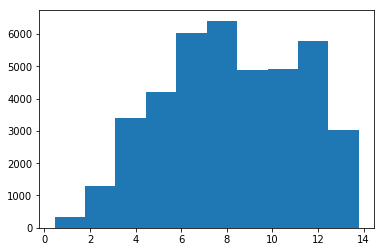

In [152]:
%pylab inline
plt.hist(star_formation_times)

Filter out any with $T<2$Gyr, or $T>13$Gyr to avoid errors:

In [190]:
good_index=np.where((star_formation_times>2.)&(star_formation_times<11.))
TNG_abuns = TNG_abun[good_index]
TNG_times = star_formation_times[good_index]
good_index2=np.where(np.max(np.abs(TNG_abuns),axis=1)<1.)
TNG_abuns = TNG_abuns[good_index2]
TNG_times = TNG_times[good_index2]

In [191]:
TNG_abun_err = np.ones_like(TNG_abuns)*0.05
TNG_times_err = (TNG_times*0.05).round(2)

In [194]:
TNG_obs_abuns =np.random.normal(loc=TNG_abuns,scale=TNG_abun_err).round(2)
TNG_obs_times=np.random.normal(loc=TNG_times,scale=TNG_times_err).round(2)

First randomize these particles:

In [199]:
jitter = np.random.choice(range(len(TNG_abuns)),replace=False,size=len(TNG_abuns))
TNG_abuns=TNG_abuns[jitter]
TNG_times=TNG_times[jitter]
TNG_obs_abuns=TNG_obs_abuns[jitter]
TNG_abun_err=TNG_abun_err[jitter]
TNG_times_err=TNG_times_err[jitter]
TNG_obs_times=TNG_obs_times[jitter]

Now save output:

In [204]:
np.savez('/mnt/store1/oliverphilcox/ChempyMultiData/TNG_Abun/TNG_Mock_Data.npz',galaxy_index=id,
        redshift=redshift,mass=mass,elements=el_names,
        abundances=TNG_obs_abuns,abundance_errs=TNG_abun_err,true_time=TNG_times,
        obs_time=TNG_obs_times,obs_time_err=TNG_times_err,true_abuns=TNG_abuns)

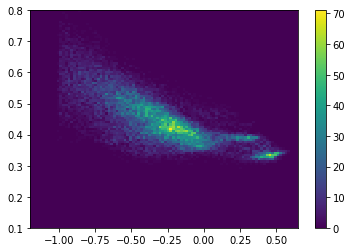

In [205]:
import matplotlib.pyplot as plt
plt.hist2d(TNG_abuns[:,1],TNG_abuns[:,6],bins=100,range=[[-1.2,0.65],[0.1,0.8]]);
plt.colorbar()
plt.show()

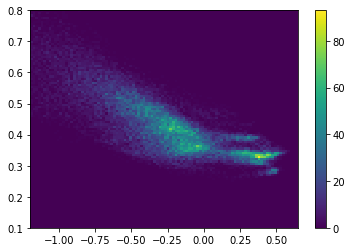

In [198]:
import matplotlib.pyplot as plt
plt.hist2d(all_abuns[:,1],all_abuns[:,6],bins=100,range=[[-1.2,0.65],[0.1,0.8]]);
plt.colorbar()
plt.show()

In [83]:
import h5py
f=h5py.File('Chempy/input/yields/TNG/AGB.hdf5','r')

In [98]:
x=f['Yields']['Z_0.0001']

In [103]:
yields=x['Yield'].value

In [108]:
np.sum(yields,axis=0)

array([ 5.9270201e-07, -1.6414492e-06, -5.5089627e-06, -4.0749914e-05,
       -7.6387165e-05, -1.1688738e-04, -1.8428492e-04, -1.1272404e-04,
       -1.9303458e-05, -1.7201983e-05, -2.1155776e-05, -3.0199088e-05,
       -3.4135704e-05, -3.9557333e-05, -3.8027087e-05, -2.0871023e-03,
       -3.3440076e-05], dtype=float32)

In [99]:
list(x.keys())

['Ejected_mass', 'Total_Metals', 'Yield']

In [89]:
list(f.keys())

['Masses',
 'Metallicities',
 'Number_of_masses',
 'Number_of_metallicities',
 'Number_of_species',
 'Reference',
 'Species_names',
 'Yield_names',
 'Yields']

In [128]:
for i in range(len(solar.all_elements)):
    if solar.all_elements[i]=='Fe':
        print(i)
    if solar.all_elements[i]=='H':
        print(i)

0
25


In [126]:
solar=solar_abundances()
getattr(solar,'Asplund09')()#5_pure_solar')()
solar.fractions[25]

0.0012919670374607077

In [127]:
solar=solar_abundances()
getattr(solar,'Asplund05_pure_solar')()
solar.fractions[25]

0.0011528226751927847

In [129]:
solar.fractions[25]/solar_fractions[0]

0.0015633661036248859

In [112]:
solar.Asplund09

<bound method solar_abundances.Asplund09 of <Chempy.solar_abundance.solar_abundances object at 0x7fc44f869cf8>>

In [125]:
np.savez('single_galaxy_TNG_abun',galaxy_index=id,simulation=which_sim,redshift=redshift,
         elements=metal_names,metal_abundances=all_abuns)

(181244, 8)

In [90]:
H_index

(array([], dtype=int64),)

In [56]:
ff=f['PartType4']
print(ff['GFM_Metals'][:])

[[6.97522521e-01 2.60323972e-01 4.65612672e-03 ... 1.72789267e-03
  1.69816788e-03 9.54122515e-04]
 [7.29375601e-01 2.50294209e-01 1.80620328e-03 ... 8.58818763e-04
  6.33493997e-04 4.31123626e-04]
 [6.73260808e-01 2.70379603e-01 6.54468872e-03 ... 2.30360241e-03
  2.62221624e-03 1.37329276e-03]
 ...
 [7.41879821e-01 2.48562321e-01 9.64688428e-04 ... 4.36709059e-04
  4.84790449e-04 2.78658641e-04]
 [7.41067767e-01 2.47793376e-01 9.82807018e-04 ... 5.03072864e-04
  4.15095041e-04 2.77052954e-04]
 [7.55702198e-01 2.41850585e-01 1.15483075e-04 ... 1.11346228e-04
  5.85147027e-05 5.55702172e-05]]


In [61]:
ff['GFM_StellarFormationTime'][:]

array([0.19171143, 0.13964944, 0.20660082, ..., 0.3868005 , 0.3357326 ,
       0.24875507], dtype=float32)

In [65]:
ff['GFM_MetalsTagged'][:]

array([[9.0689055e-04, 3.7806232e-02, 3.4404143e-03, 2.1186993e-03,
        4.9365772e-04, 1.1012619e-03],
       [2.6155429e-04, 1.9576987e-02, 4.9166888e-04, 3.1098558e-04,
        1.4314937e-04, 4.8320933e-04],
       [1.6935718e-03, 4.5719147e-02, 8.9469124e-03, 4.3223961e-03,
        9.1501931e-04, 1.4034363e-03],
       ...,
       [4.7836083e-04, 7.4798502e-03, 1.5996499e-03, 1.5364431e-03,
        2.5447318e-04, 1.8637045e-04],
       [3.2172166e-04, 9.9975476e-03, 8.1958505e-04, 8.3742948e-04,
        1.6801203e-04, 2.3282628e-04],
       [3.9669150e-05, 2.2940210e-03, 1.1350744e-04, 7.8073877e-05,
        1.9030513e-05, 3.7282891e-05]], dtype=float32)

In [58]:
ff.items()

[(u'BirthPos', <HDF5 dataset "BirthPos": shape (22579, 3), type "<f4">),
 (u'BirthVel', <HDF5 dataset "BirthVel": shape (22579, 3), type "<f4">),
 (u'Coordinates', <HDF5 dataset "Coordinates": shape (22579, 3), type "<f8">),
 (u'GFM_InitialMass',
  <HDF5 dataset "GFM_InitialMass": shape (22579,), type "<f4">),
 (u'GFM_Metallicity',
  <HDF5 dataset "GFM_Metallicity": shape (22579,), type "<f4">),
 (u'GFM_Metals', <HDF5 dataset "GFM_Metals": shape (22579, 10), type "<f4">),
 (u'GFM_MetalsTagged',
  <HDF5 dataset "GFM_MetalsTagged": shape (22579, 6), type "<f4">),
 (u'GFM_StellarFormationTime',
  <HDF5 dataset "GFM_StellarFormationTime": shape (22579,), type "<f4">),
 (u'GFM_StellarPhotometrics',
  <HDF5 dataset "GFM_StellarPhotometrics": shape (22579, 8), type "<f4">),
 (u'Masses', <HDF5 dataset "Masses": shape (22579,), type "<f4">),
 (u'ParticleIDs', <HDF5 dataset "ParticleIDs": shape (22579,), type "<u8">),
 (u'Potential', <HDF5 dataset "Potential": shape (22579,), type "<f4">),
 (u'S

In [66]:
import h5py
import numpy as np

which_sim = 'TNG100-1'
id = 21
redshift = 0.0
params = {'gas':'all'}

scale_factor = 1.0 / (1+redshift)
little_h = 0.704
solar_Z = 0.0127

url = "http://www.tng-project.org/api/"+str(which_sim)+"/snapshots/z=" + str(redshift) + "/subhalos/" + str(id)
print(url)
sub = get(url) # get json response of subhalo properties
saved_filename = get(url + "/cutout.hdf5",params) # get and save HDF5 cutout file

http://www.tng-project.org/api/TNG300-1/snapshots/z=0.0/subhalos/21


In [76]:
f2=h5py.File(saved_filename)
ff2=f2['PartType4']
ff2.items()
ff2['GFM_Metals'][:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [74]:
ff2['GFM_MetalsTagged'][:]

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
 import h5py
>>> import numpy as np
>>>
>>> id = 109974
>>> redshift = 2.0
>>> params = {'stars':'Coordinates,GFM_Metallicity'}
>>>
>>> scale_factor = 1.0 / (1+redshift)
>>> little_h = 0.704
>>> solar_Z = 0.0127
>>>
>>> url = "http://www.tng-project.org/api/Illustris-1/snapshots/z=" + str(redshift) + "/subhalos/" + str(id)
>>> sub = get(url) # get json response of subhalo properties
>>> saved_filename = get(url + "/cutout.hdf5",params) # get and save HDF5 cutout file
>>>
>>> with h5py.File(saved_filename) as f:
>>>     # NOTE! If the subhalo is near the edge of the box, you must take the periodic boundary into account! (we ignore it here)
>>>     dx = f['PartType4']['Coordinates'][:,0] - sub['pos_x']
>>>     dy = f['PartType4']['Coordinates'][:,1] - sub['pos_y']
>>>     dz = f['PartType4']['Coordinates'][:,2] - sub['pos_z']
>>>     metals = f['PartType4']['GFM_Metallicity'][:]
>>> 
>>>     rr = np.sqrt(dx**2 + dy**2 + dz**2)
>>>     rr *= scale_factor/little_h # ckpc/h -> physical kpc
>>> 
>>>     w = np.where( (rr >= 3.0) & (rr < 5.0) )    
>>>     print np.mean( metals[w] ) / solar_Z

0.248392603881

In [9]:
# first convert log solar masses into group catalog units
>>> mass_min = 10**11.9 / 1e10 * 0.704
>>> mass_max = 10**12.1 / 1e10 * 0.704

>>> # form the search_query string by hand for once
>>> search_query = "?mass__gt=" + str(mass_min) + "&mass__lt=" + str(mass_max)
>>> search_query
'?mass__gt=55.9207077246&mass__lt=88.6283489903'

>>> # form the url and make the request
>>> a
>>> subhalos = get(url)
>>> subhalos['count']
550

>>> ids = [ subhalos['results'][i]['id'] for i in range(5) ]
>>> ids
[109974, 110822, 123175, 107743, 95711]

[u'gasmetallicitysfr',
 u'massinrad_bhs',
 u'supplementary_data',
 u'starmetallicity',
 u'stellarphotometrics_b',
 u'grnr',
 u'spin_x',
 u'massinhalfrad_gas',
 u'stellarphotometrics_i',
 u'stellarphotometricsmassinrad',
 u'stellarphotometrics_k',
 u'primary_flag',
 u'stellarphotometrics_u',
 u'massinmaxrad_stars',
 u'stellarphotometrics_g',
 u'meta',
 u'mass_log_msun',
 u'len_bhs',
 u'massinrad_stars',
 u'windmass',
 u'vel_z',
 u'veldisp',
 u'id',
 u'massinhalfrad_stars',
 u'parent',
 u'vis',
 u'sfrinmaxrad',
 u'halfmassrad_bhs',
 u'vmaxrad',
 u'gasmetallicitysfrweighted',
 u'starmetallicitymaxrad',
 u'halfmassrad_dm',
 u'trees',
 u'halfmassrad_stars',
 u'massinhalfrad_bhs',
 u'massinmaxrad_gas',
 u'massinrad',
 u'mass_dm',
 u'vel_y',
 u'mass_bhs',
 u'stellarphotometrics_z',
 u'snap',
 u'spin_z',
 u'massinhalfrad',
 u'sfrinrad',
 u'gasmetallicityhalfrad',
 u'sfrinhalfrad',
 u'cutouts',
 u'mass_stars',
 u'stellarphotometrics_r',
 u'cm_y',
 u'cm_x',
 u'bhmdot',
 u'cm_z',
 u'massinrad_dm'